In [9]:
import findspark
findspark.init()


In [41]:
from pyspark.sql import SparkSession

# Créer une nouvelle session Spark
spark = SparkSession.builder \
    .appName("MonNotebookSpark") \
    .master("local[*]") \
    .getOrCreate()

# Vérifier la version de Spark
print(spark.version)

3.5.3


In [1]:
import numpy as np
import pandas as pd


In [2]:

# Charger un fichier texte avec des délimiteurs (par exemple, tabulation, espace ou virgule)
X = pd.read_csv("individual+household+electric+power+consumption/household_power_consumption.txt", delimiter=";")  # Changez delimiter selon le séparateur utilisé

# Afficher les premières lignes
print(X.head())


         Date      Time Global_active_power Global_reactive_power  Voltage  \
0  16/12/2006  17:24:00               4.216                 0.418  234.840   
1  16/12/2006  17:25:00               5.360                 0.436  233.630   
2  16/12/2006  17:26:00               5.374                 0.498  233.290   
3  16/12/2006  17:27:00               5.388                 0.502  233.740   
4  16/12/2006  17:28:00               3.666                 0.528  235.680   

  Global_intensity Sub_metering_1 Sub_metering_2  Sub_metering_3  
0           18.400          0.000          1.000            17.0  
1           23.000          0.000          1.000            16.0  
2           23.000          0.000          2.000            17.0  
3           23.000          0.000          1.000            17.0  
4           15.800          0.000          1.000            17.0  


/tmp/ipykernel_5374/2630728193.py:2: DtypeWarning: Columns (2,3,4,5,6,7) have mixed types. Specify dtype option on import or set low_memory=False.
  X = pd.read_csv("individual+household+electric+power+consumption/household_power_consumption.txt", delimiter=";")  # Changez delimiter selon le séparateur utilisé


In [3]:
# Si X est un DataFrame PySpark
df_pandas = X.toPandas()


AttributeError: 'DataFrame' object has no attribute 'toPandas'

In [4]:
print(X.shape)


(2075259, 9)


In [5]:

# Sélectionner les colonnes numériques
numeric_columns = X.select_dtypes(include=['float64', 'int64']).columns

# Remplacer les valeurs manquantes dans les colonnes numériques par la médiane
X[numeric_columns] = X[numeric_columns].fillna(X[numeric_columns].median())

# Vérifier s'il y a encore des valeurs manquantes
print(X.isnull().sum())

# Vérifier les types après conversion
print(X.dtypes)


Date                     0
Time                     0
Global_active_power      0
Global_reactive_power    0
Voltage                  0
Global_intensity         0
Sub_metering_1           0
Sub_metering_2           0
Sub_metering_3           0
dtype: int64
Date                      object
Time                      object
Global_active_power       object
Global_reactive_power     object
Voltage                   object
Global_intensity          object
Sub_metering_1            object
Sub_metering_2            object
Sub_metering_3           float64
dtype: object


In [ ]:

# Convertir les colonnes numériques en float
X['Global_active_power'] = pd.to_numeric(X['Global_active_power'], errors='coerce')
X['Global_reactive_power'] = pd.to_numeric(X['Global_reactive_power'], errors='coerce')
X['Voltage'] = pd.to_numeric(X['Voltage'], errors='coerce')
X['Global_intensity'] = pd.to_numeric(X['Global_intensity'], errors='coerce')
X['Sub_metering_1'] = pd.to_numeric(X['Sub_metering_1'], errors='coerce')
X['Sub_metering_2'] = pd.to_numeric(X['Sub_metering_2'], errors='coerce')
X['Sub_metering_3'] = pd.to_numeric(X['Sub_metering_3'], errors='coerce')

# Supprimer les colonnes Date et Time après la conversion
X.drop(columns=['Date', 'Time'], inplace=True)

print(X.dtypes)


Global_active_power      float64
Global_reactive_power    float64
Voltage                  float64
Global_intensity         float64
Sub_metering_1           float64
Sub_metering_2           float64
Sub_metering_3           float64
dtype: object


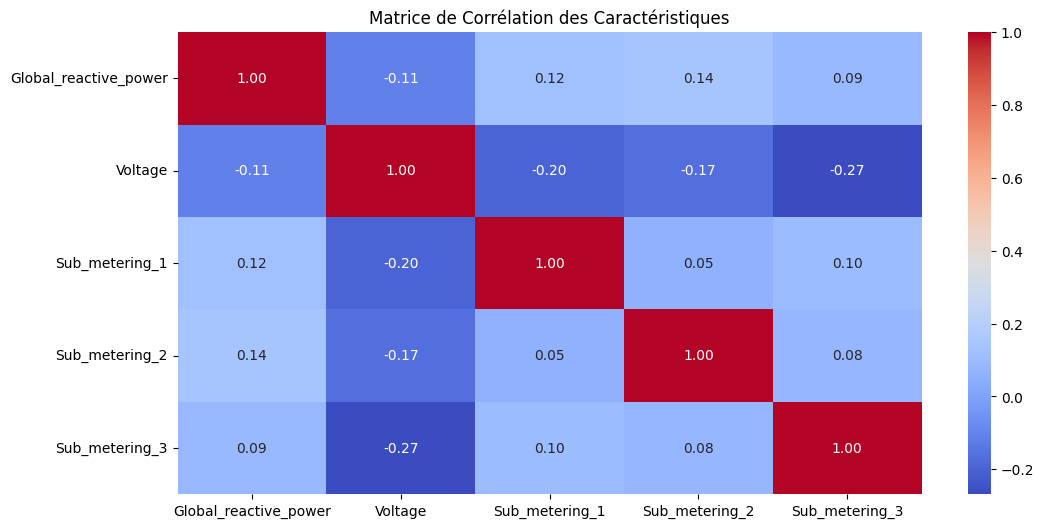

In [14]:
# Visualiser la distribution des variables
import seaborn as sns
import matplotlib.pyplot as plt

# Visualiser la relation entre certaines variables
plt.figure(figsize=(12, 6))
sns.heatmap(X.corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Matrice de Corrélation des Caractéristiques')
plt.show()


In [7]:
from sklearn.model_selection import train_test_split

y = X['Global_active_power']

# Toutes les autres colonnes seront utilisées comme caractéristiques (X)
X = X.drop(columns=['Global_active_power', 'Global_intensity'])

# Diviser les données en entraînement et test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)




In [8]:
print(X_train.isna().sum())  # Vérifiez les valeurs manquantes dans les données d'entraînement
print(X_test.isna().sum())   # Vérifiez les valeurs manquantes dans les données de test


Global_reactive_power    20726
Voltage                  20726
Sub_metering_1           20726
Sub_metering_2           20726
Sub_metering_3               0
dtype: int64
Global_reactive_power    5253
Voltage                  5253
Sub_metering_1           5253
Sub_metering_2           5253
Sub_metering_3              0
dtype: int64


In [9]:
# Supprimer les lignes contenant des NaN
X_train = X_train.dropna()
y_train = y_train[X_train.index]
X_test = X_test.dropna()
y_test = y_test[X_test.index]


In [10]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# Initialiser le modèle
model = LinearRegression()

# Entraîner le modèle
model.fit(X_train, y_train)

# Prédire sur l'ensemble de test
y_pred = model.predict(X_test)

# Évaluer les performances du modèle
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'MSE: {mse}')
print(f'R²: {r2}')


MSE: 0.2899281354212601
R²: 0.7407979221853667


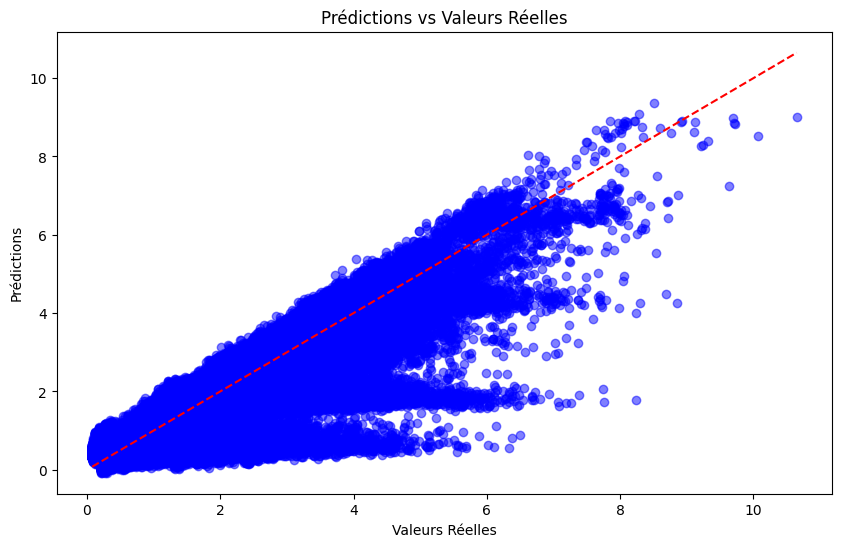

In [15]:
# Visualiser les prédictions vs les valeurs réelles
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5, color='blue')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--', color='red')  # ligne de référence
plt.xlabel('Valeurs Réelles')
plt.ylabel('Prédictions')
plt.title('Prédictions vs Valeurs Réelles')
plt.show()


In [16]:
from lightgbm import LGBMRegressor

# Initialiser le modèle LightGBM
lgbm_model = LGBMRegressor(n_estimators=100, random_state=42)

# Entraîner le modèle
lgbm_model.fit(X_train, y_train)



[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.053028 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 687
[LightGBM] [Info] Number of data points in the train set: 1639481, number of used features: 5
[LightGBM] [Info] Start training from score 1.091416


LGBMRegressor(random_state=42)

In [17]:
# Prédire
lgbm_y_pred = lgbm_model.predict(X_test)

# Évaluer les performances
lgbm_mse = mean_squared_error(y_test, lgbm_y_pred)
lgbm_r2 = r2_score(y_test, lgbm_y_pred)

print(f'MSE (LightGBM): {lgbm_mse}')
print(f'R² (LightGBM): {lgbm_r2}')


MSE (LightGBM): 0.2574590853097045
R² (LightGBM): 0.7698259612935903


In [ ]:
# Ajouter une colonne calculée
from pyspark.sql.functions import col
df = df.withColumn("NouvelleColonne", col("Colonne1") * 2)

In [18]:
import joblib

# Supposons que ton modèle s'appelle 'model' après son entraînement
joblib.dump(model, 'model.pkl')
joblib.dump(lgbm_model, 'lgbm_model.pkl')

['lgbm_model.pkl']